<a href="https://colab.research.google.com/github/cardstdani/practica-par/blob/main/PracticaParadigmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Práctica Paradigmas 1**

In [ ]:
!pip install pyvis==0.3.1

Error al cargar el fichero tablero, usando tablero aleatorio...
Error al cargar el fichero secuencia, usando secuencia aleatoria...
Que empiece el juego:😉


,0,1,2,3,4,5,6,7,8,9
A,a,.,.,.,.,b,.,.,c,a
B,.,.,.,a,.,.,c,b,.,.
C,.,.,a,.,.,.,.,a,b,.
D,.,.,c,a,a,a,.,.,.,b
E,.,a,c,.,.,.,.,.,a,.
F,a,.,a,a,1,.,b,.,.,.
G,.,.,.,.,b,.,.,.,a,.
H,.,.,.,a,a,.,a,a,b,c
I,.,.,c,.,.,b,.,a,.,a
J,.,.,.,.,.,.,a,1,.,b



Turno: 0 Puntos:166
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,.,.,.,b,.,.,c,a
B,.,.,.,a,.,.,c,b,.,.
C,.,.,a,.,.,.,.,a,b,.
D,.,.,c,a,a,a,.,.,.,b
E,.,a,c,.,.,.,.,.,a,.
F,a,.,a,a,1,.,b,.,.,.
G,.,.,.,.,b,.,.,.,a,.
H,.,.,.,a,a,.,a,a,b,c
I,.,.,c,.,.,b,.,a,.,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 1 Puntos:187
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,.,.,.,b,.,.,c,a
B,.,.,.,a,.,.,c,b,.,.
C,.,.,a,.,.,.,.,a,b,.
D,.,.,c,.,.,.,.,.,.,b
E,.,a,c,b,1,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,.,b,.,.,.,a,.
H,.,.,.,a,a,.,a,a,b,c
I,.,.,c,.,.,b,.,a,.,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 2 Puntos:187
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,.,.,.,.,b,.,.,c,a
B,.,.,.,a,.,.,c,b,.,.
C,.,.,a,.,.,.,.,a,b,.
D,.,.,c,.,1,.,.,.,.,b
E,.,a,c,b,.,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,.,b,.,.,.,a,.
H,.,.,.,a,a,.,a,a,b,c
I,.,.,c,.,.,b,2,a,.,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 3 Puntos:182
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,.,.,.,.,b,.,.,c,a
B,.,.,.,a,.,.,c,b,.,.
C,.,.,a,.,1,.,.,a,b,.
D,.,.,c,.,.,.,.,.,.,b
E,.,a,c,b,.,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,.,b,.,.,.,a,.
H,.,.,.,a,a,.,a,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 4 Puntos:177
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,.,.,.,b,.,.,c,a
B,.,.,.,a,1,.,c,b,.,.
C,.,.,a,.,.,.,.,a,b,.
D,.,.,c,.,.,.,.,.,.,b
E,.,a,c,b,.,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,.,.,a,.
H,.,.,.,.,.,.,a,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 5 Puntos:180
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,.,.,1,b,.,.,c,a
B,.,.,.,a,.,.,c,b,.,.
C,.,.,a,.,.,.,.,a,b,.
D,.,.,c,.,.,.,.,.,.,b
E,.,a,c,b,.,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 6 Puntos:182
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,.,.,.,.,b,.,.,c,a
B,.,.,.,a,1,1,c,b,.,.
C,.,.,a,.,.,.,.,a,b,.
D,.,.,c,.,.,.,.,.,.,b
E,.,a,c,b,.,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 7 Puntos:157
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,.,1,b,.,.,c,a
B,.,.,.,a,.,.,c,b,.,.
C,.,.,a,.,.,1,.,a,b,.
D,.,.,c,.,.,.,.,.,.,b
E,.,a,c,b,.,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 8 Puntos:158
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,a,.,b,.,.,c,a
B,.,.,.,a,1,1,c,b,.,.
C,.,.,a,.,.,.,.,a,b,.
D,.,.,c,.,.,.,.,.,.,b
E,.,a,c,b,.,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 9 Puntos:159
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,.,b,b,.,.,c,a
B,.,.,.,.,.,.,c,b,.,.
C,.,.,a,.,1,1,.,a,b,.
D,.,.,c,.,.,.,.,.,.,b
E,.,a,c,b,.,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 10 Puntos:162
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,.,b,b,.,.,c,a
B,.,.,a,.,1,1,c,b,.,.
C,.,.,a,.,.,.,.,a,b,.
D,.,.,c,.,.,.,.,.,.,b
E,.,a,c,b,.,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 11 Puntos:163
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,.,b,b,.,.,c,a
B,.,.,a,.,x,2,c,b,.,.
C,.,.,a,.,1,b,.,a,b,.
D,.,.,c,.,.,.,.,.,.,b
E,.,a,c,b,.,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 12 Puntos:138
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,.,b,b,.,.,c,a
B,.,.,a,.,x,2,c,b,.,a
C,.,.,a,.,x,b,.,a,b,.
D,.,.,c,.,1,.,.,.,.,b
E,.,a,c,b,.,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 13 Puntos:89
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,.,b,b,.,.,c,.
B,.,.,a,.,x,2,c,.,c,.
C,.,.,a,.,x,b,.,a,.,.
D,.,.,c,.,x,1,.,.,.,b
E,.,a,c,b,.,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 14 Puntos:52
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,.,b,b,.,.,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,.,a,.,.
D,.,.,c,.,x,x,1,.,.,b
E,.,a,c,b,.,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 15 Puntos:3
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,.,b,b,.,.,c,.
B,.,.,a,.,x,2,c,.,c,.
C,.,.,a,.,x,b,b,.,.,.
D,.,.,c,.,x,x,x,1,.,b
E,.,a,c,b,.,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 16 Puntos:-44
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,.,b,b,.,.,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,1,.,.
D,.,.,c,.,x,x,x,x,.,b
E,.,a,c,b,.,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 17 Puntos:-93
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,.,b,b,.,.,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,2,a,.
D,.,.,c,.,x,x,x,x,.,b
E,.,a,c,b,.,.,.,.,a,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 18 Puntos:-72
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,.,b,b,.,.,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,2,.,.
D,.,.,c,.,x,x,x,x,b,b
E,.,a,c,b,.,.,.,.,.,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 19 Puntos:-69
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,.,b,b,.,a,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,2,.,.
D,.,.,c,.,x,x,x,x,b,b
E,.,a,c,b,.,.,.,.,.,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 20 Puntos:-68
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,.,.,.,c,.,c,.
B,.,.,a,.,x,2,c,.,c,.
C,.,.,a,.,x,b,b,2,.,.
D,.,.,c,.,x,x,x,x,b,b
E,.,a,c,b,.,.,.,.,.,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 21 Puntos:-55
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,.,.,1,c,.,c,.
B,.,.,a,.,x,2,c,.,c,.
C,.,.,a,.,x,b,b,2,.,.
D,.,.,c,.,x,x,x,x,b,b
E,.,a,c,b,.,.,.,.,.,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 22 Puntos:-80
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,.,a,2,c,.,c,.
B,.,.,a,.,x,2,c,.,c,.
C,.,.,a,.,x,b,b,2,.,.
D,.,.,c,.,x,x,x,x,b,b
E,.,a,c,b,.,.,.,.,.,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 23 Puntos:-59
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,a,a,2,c,.,c,.
B,.,.,a,.,x,2,c,.,c,.
C,.,.,a,.,x,b,b,2,.,.
D,.,.,c,.,x,x,x,x,b,b
E,.,a,c,b,.,.,.,.,.,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 24 Puntos:-58
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,a,a,2,c,.,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,2,.,.
D,.,.,c,.,x,x,x,x,b,b
E,.,a,c,b,.,.,.,.,.,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 25 Puntos:-57
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,a,a,2,c,a,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,2,.,.
D,.,.,c,.,x,x,x,x,b,b
E,.,a,c,b,.,.,.,.,.,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 26 Puntos:-56
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,a,a,2,c,a,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,2,a,.
D,.,.,c,.,x,x,x,x,b,b
E,.,a,c,b,.,.,.,.,.,.
F,a,.,.,.,.,.,b,.,.,.
G,.,.,.,b,b,.,b,.,a,.
H,.,.,.,.,.,.,.,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 27 Puntos:-55
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,a,.,a,a,2,c,a,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,2,a,.
D,.,.,c,.,x,x,x,x,b,b
E,.,a,c,b,.,.,.,.,.,.
F,a,.,.,.,.,.,.,.,.,.
G,.,.,.,b,b,.,.,.,a,.
H,.,.,.,.,.,.,c,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 28 Puntos:-40
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,a,2,a,a,2,c,a,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,2,a,.
D,.,.,c,.,x,x,x,x,b,b
E,.,a,c,b,.,.,.,.,.,.
F,a,.,.,.,.,.,.,.,.,.
G,.,.,.,b,b,.,.,.,a,.
H,.,.,.,.,.,.,c,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 29 Puntos:-45
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,2,a,a,2,c,a,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,2,a,a
D,.,.,c,.,x,x,x,x,b,b
E,.,a,c,b,.,.,.,.,.,.
F,a,.,.,.,.,.,.,.,.,.
G,.,.,.,b,b,.,.,.,a,.
H,.,.,.,.,.,.,c,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 30 Puntos:-44
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,2,a,a,2,c,a,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,b,b
E,.,a,c,b,.,.,.,.,.,.
F,a,.,.,.,.,.,.,.,.,.
G,.,.,.,b,b,.,.,.,a,.
H,.,.,.,.,.,.,c,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 31 Puntos:-43
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,2,a,a,2,c,a,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,b,b
E,.,a,c,b,.,.,.,.,.,.
F,a,.,.,.,.,.,.,.,a,.
G,.,.,.,b,b,.,.,.,a,.
H,.,.,.,.,.,.,c,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 32 Puntos:-42
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,2,a,a,2,c,a,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,b,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,.,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 33 Puntos:-29
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,2,a,a,2,c,a,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,b,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,.,b,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 34 Puntos:-28
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,2,a,a,2,c,a,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,b,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,.,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 35 Puntos:-27
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,2,a,a,2,c,a,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,b,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 36 Puntos:-26
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,a,2,a,a,2,c,a,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,.,x,b,b,2,a,a
D,.,a,c,b,x,x,x,x,.,.
E,.,a,c,b,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 37 Puntos:-21
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,2,a,a,2,c,a,c,.
B,.,.,.,.,x,2,c,a,c,.
C,.,.,.,c,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 38 Puntos:-8
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,2,a,a,2,c,a,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,.,c,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 39 Puntos:-7
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,2,a,a,2,c,a,c,.
B,.,.,a,.,x,2,c,a,c,.
C,.,.,a,c,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 40 Puntos:-6
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,a,2,a,a,2,c,a,c,.
B,.,.,a,2,x,2,c,a,c,.
C,.,.,a,c,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,.,a,2,a,b



Turno: 41 Puntos:-11
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,a,2,a,a,2,c,a,c,.
B,.,.,a,2,x,2,c,a,c,.
C,.,.,a,c,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 42 Puntos:-10
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,.,2,a,a,2,c,a,c,.
B,b,.,a,2,x,2,c,a,c,.
C,.,.,a,c,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 43 Puntos:-7
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,.,2,a,a,2,c,a,c,.
B,b,b,.,2,x,2,c,a,c,.
C,.,.,.,c,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 44 Puntos:-4
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,.,c,2,a,a,2,c,a,c,.
B,.,.,.,2,x,2,c,a,c,.
C,.,.,.,c,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 45 Puntos:11
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,.,c,2,a,a,2,c,a,c,.
B,.,.,b,2,x,2,c,a,c,.
C,.,.,.,c,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 46 Puntos:16
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,1,c,2,a,a,2,c,a,c,.
B,.,.,b,2,x,2,c,a,c,.
C,.,.,.,c,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 47 Puntos:-9
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,.
B,a,.,b,2,x,2,c,a,c,.
C,.,.,.,c,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 48 Puntos:12
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,.
B,a,a,b,2,x,2,c,a,c,.
C,.,.,.,c,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 49 Puntos:13
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,.
B,a,a,b,2,x,2,c,a,c,.
C,.,.,b,c,x,b,b,2,a,a
D,.,a,c,.,x,x,x,x,.,.
E,.,a,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 50 Puntos:18
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,.
B,.,.,.,2,x,2,c,a,c,.
C,.,c,.,c,x,b,b,2,a,a
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 51 Puntos:29
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,.
B,1,.,.,2,x,2,c,a,c,.
C,.,c,.,c,x,b,b,2,a,a
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 52 Puntos:4
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,.
B,.,1,a,2,x,2,c,a,c,.
C,.,c,.,c,x,b,b,2,a,a
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 53 Puntos:5
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,.
B,a,2,a,2,x,2,c,a,c,.
C,.,c,.,c,x,b,b,2,a,a
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 54 Puntos:26
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,.,d
B,a,2,a,2,x,2,c,a,.,.
C,.,c,.,c,x,b,b,2,a,a
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,.,.,c,.
F,a,.,.,.,.,.,.,.,.,.
G,a,.,.,b,b,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 55 Puntos:101
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,.,d
B,a,2,a,2,x,2,c,a,.,.
C,.,c,.,c,x,b,b,2,a,a
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,.,.,c,.
F,a,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 56 Puntos:116
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,.,d
B,a,2,a,2,x,2,c,a,.,.
C,.,c,2,c,x,b,b,2,a,a
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,.,.,c,.
F,a,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,.,.,.,.,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 57 Puntos:111
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,.,d
B,a,2,a,2,x,2,c,a,.,.
C,.,c,2,c,x,b,b,2,a,a
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,.,.,c,.
F,a,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,.,.,.,b,.
H,.,.,.,.,.,.,c,a,b,c
I,.,.,c,.,.,b,2,a,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 58 Puntos:116
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,.,d
B,a,2,a,2,x,2,c,a,.,.
C,.,c,2,c,x,b,b,2,a,a
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,.,.,c,.
F,a,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 59 Puntos:129
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,.,d
B,a,2,a,2,x,2,c,a,.,.
C,.,c,2,c,x,b,b,2,a,a
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,.,.,c,.
F,a,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,1,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 60 Puntos:104
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,.,d
B,a,2,a,2,x,2,c,a,.,.
C,a,c,2,c,x,b,b,2,a,a
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,.,.,c,.
F,a,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,.,.,c,1,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 61 Puntos:105
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,.,d
B,a,2,a,2,x,2,c,a,.,.
C,a,c,2,c,x,b,b,2,a,a
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,.,.,c,.
F,a,.,.,c,.,.,.,1,1,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 62 Puntos:80
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,.,d
B,a,2,a,2,x,2,c,a,.,.
C,a,c,2,c,x,b,b,2,a,a
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,a,1,c,.
F,a,.,.,c,.,.,.,.,.,1
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 63 Puntos:81
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,.,d
B,a,2,a,2,x,2,c,a,.,.
C,a,c,2,c,x,b,b,2,a,a
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,a,2,c,1
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 64 Puntos:102
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,.,d
B,a,2,a,2,x,2,c,a,.,.
C,a,c,2,c,x,b,b,2,.,.
D,.,.,c,.,x,x,x,x,b,1
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 65 Puntos:105
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,.,d
B,a,2,a,2,x,2,c,a,.,b
C,a,c,2,c,x,b,b,2,.,1
D,.,.,c,.,x,x,x,x,b,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 66 Puntos:110
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,.,.,d
B,a,2,a,2,x,2,c,.,b,b
C,a,c,2,c,x,b,b,2,.,.
D,.,.,c,.,x,x,x,x,b,1
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 67 Puntos:113
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,.,.,d
B,a,2,a,2,x,2,c,a,b,b
C,a,c,2,c,x,b,b,2,.,1
D,.,.,c,.,x,x,x,x,b,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 68 Puntos:114
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,.,d
B,a,2,a,2,x,2,c,a,b,b
C,a,c,2,c,x,b,b,2,.,.
D,.,.,c,.,x,x,x,x,b,1
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 69 Puntos:115
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,.,c,d
B,a,2,a,2,x,2,c,.,.,.
C,a,c,2,c,x,b,b,2,.,1
D,.,.,c,.,x,x,x,x,b,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 70 Puntos:128
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,.,c,d
B,a,2,a,2,x,2,c,a,.,1
C,a,c,2,c,x,b,b,2,.,x
D,.,.,c,.,x,x,x,x,b,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 71 Puntos:79
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,.,c,d
B,a,2,a,2,x,2,c,a,a,2
C,a,c,2,c,x,b,b,2,.,x
D,.,.,c,.,x,x,x,x,b,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 72 Puntos:100
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,.,c,d
B,a,2,a,2,x,2,c,.,.,2
C,a,c,2,c,x,b,b,2,b,x
D,.,.,c,.,x,x,x,x,b,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 73 Puntos:103
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,.,c,d
B,a,2,a,2,x,2,c,a,.,2
C,a,c,2,c,x,b,b,2,b,x
D,.,.,c,.,x,x,x,x,b,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 74 Puntos:104
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,x,2,c,a,.,2
C,a,c,2,c,x,b,b,2,b,x
D,.,.,c,.,x,x,x,x,b,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 75 Puntos:105
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,.,c,d
B,a,2,a,2,x,2,c,.,c,2
C,a,c,2,c,x,b,b,2,.,x
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 76 Puntos:118
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,.,c,d
B,a,2,a,2,.,2,c,.,c,2
C,a,c,2,c,x,b,b,2,.,x
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 77 Puntos:168
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,.,.,2,c,.,c,d
B,a,2,a,2,b,2,c,.,c,2
C,a,c,2,c,x,b,b,2,.,x
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 78 Puntos:171
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,.,2,c,.,c,d
B,a,2,a,2,b,2,c,.,c,2
C,a,c,2,c,x,b,b,2,.,x
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 79 Puntos:172
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,.,c,d
B,a,2,a,2,b,2,c,.,c,2
C,a,c,2,c,x,b,b,2,.,x
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 80 Puntos:173
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,.,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,.,x
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 81 Puntos:174
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,.,x
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 82 Puntos:175
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,.,c,.,x,x,x,x,.,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 83 Puntos:176
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,.,c,.,x,x,x,x,a,.
E,.,.,c,.,.,.,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 84 Puntos:177
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,.,c,.,x,x,x,x,a,.
E,.,.,c,.,.,a,a,2,c,.
F,a,.,.,c,.,.,.,a,.,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 85 Puntos:178
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,.,c,.,x,x,x,x,a,.
E,.,.,c,.,.,a,a,2,c,.
F,a,.,.,c,.,.,.,a,a,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 86 Puntos:179
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,.,c,.,x,x,x,x,a,.
E,.,.,c,.,.,a,a,2,c,.
F,a,.,.,c,.,.,.,a,a,.
G,a,.,.,.,.,.,.,c,.,.
H,.,.,.,.,.,.,c,.,1,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 87 Puntos:154
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,.,c,.,x,x,x,x,a,.
E,.,.,c,.,.,a,a,2,c,.
F,a,.,.,c,.,.,.,a,a,.
G,a,.,.,.,.,.,.,c,1,a
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 88 Puntos:155
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,.,c,.,x,x,x,x,a,.
E,.,.,c,.,.,a,a,2,c,.
F,a,.,.,c,.,.,.,a,a,.
G,a,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,.,a,c
I,.,.,c,.,.,b,2,.,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 89 Puntos:176
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,.,c,.,x,x,x,x,a,.
E,.,.,c,.,.,a,a,2,c,.
F,a,.,.,c,.,.,.,a,a,.
G,a,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,.,a,c
I,.,.,c,.,.,b,2,1,2,a
J,.,.,.,.,.,a,a,2,a,b



Turno: 90 Puntos:151
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,.,c,.,x,x,x,x,a,.
E,.,.,c,.,.,a,a,2,c,.
F,a,.,.,c,.,.,.,a,a,.
G,a,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,b,.,.,.,a
J,.,.,.,.,.,a,a,3,a,b



Turno: 91 Puntos:242
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,.,c,.,x,x,x,x,a,.
E,.,.,c,.,.,a,a,2,c,.
F,a,.,.,c,.,.,.,a,a,.
G,a,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,b,b,.,.,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 92 Puntos:245
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,.,c,.,x,x,x,x,a,.
E,.,.,c,.,.,a,a,2,c,.
F,a,.,.,c,.,.,.,a,a,.
G,a,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,.,.,c
I,.,.,c,.,.,.,.,c,.,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 93 Puntos:258
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,.,c,.,x,x,x,x,a,.
E,.,.,c,.,.,a,a,2,c,.
F,a,.,.,c,.,.,.,a,a,.
G,a,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,.,a,c
I,.,.,c,.,.,.,.,c,.,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 94 Puntos:259
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,.,c,.,x,x,x,x,a,.
E,.,.,c,.,.,a,a,2,c,.
F,a,.,.,c,.,.,.,a,a,.
G,a,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,.,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 95 Puntos:260
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,.,2,a,2,b,2,c,a,c,2
C,.,c,2,c,x,b,b,2,a,x
D,b,.,c,.,x,x,x,x,a,.
E,.,.,c,.,.,a,a,2,c,.
F,a,.,.,c,.,.,.,a,a,.
G,a,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,.,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 96 Puntos:263
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,.,2,a,2,b,2,c,a,c,2
C,.,c,2,c,x,b,b,2,a,x
D,b,.,c,.,x,x,x,x,a,.
E,b,.,c,.,.,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,.,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 97 Puntos:266
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,.,c,2,c,x,b,b,2,a,x
D,b,.,c,.,x,x,x,x,a,.
E,b,.,c,.,.,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,.,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 98 Puntos:267
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,b,.,c,.,x,x,x,x,a,.
E,b,.,c,.,.,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,.,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 99 Puntos:268
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,.,x
D,b,.,c,.,x,x,x,x,.,b
E,b,.,c,.,.,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,.,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 100 Puntos:271
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,b,.,c,.,x,x,x,x,.,b
E,b,.,c,.,.,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,.,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 101 Puntos:272
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,b,.,c,.,x,x,x,x,a,b
E,b,.,c,.,.,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,.,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 102 Puntos:273
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,b,.,c,.,x,x,x,x,a,b
E,b,.,c,.,b,.,.,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,.,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 103 Puntos:276
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,b,.,c,.,x,x,x,x,a,b
E,b,.,c,.,b,.,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,.,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 104 Puntos:277
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,b,.,c,.,x,x,x,x,a,b
E,b,.,c,.,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,.,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 105 Puntos:278
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,b,.,c,.,x,x,x,x,a,b
E,b,.,c,.,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 106 Puntos:273
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,b,.,c,.,x,x,x,x,a,b
E,b,.,c,.,b,.,.,2,c,.
F,.,.,.,c,.,b,.,a,a,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 107 Puntos:276
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,b,.,c,.,x,x,x,x,a,b
E,b,.,c,.,b,.,.,2,c,.
F,.,.,.,c,.,b,b,.,.,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 108 Puntos:279
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,b,.,c,.,x,x,x,x,a,b
E,b,.,c,.,b,.,a,2,c,.
F,.,.,.,c,.,b,b,.,.,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 109 Puntos:280
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,.,.,.,x,x,x,x,a,b
E,.,d,.,.,b,.,a,2,c,.
F,.,.,.,c,.,b,b,.,.,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 110 Puntos:345
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,.,a,.,x,x,x,x,a,b
E,.,d,.,.,b,.,a,2,c,.
F,.,.,.,c,.,b,b,.,.,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 111 Puntos:346
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,a,a,.,x,x,x,x,a,b
E,.,d,.,.,b,.,a,2,c,.
F,.,.,.,c,.,b,b,.,.,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 112 Puntos:347
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,a,a,.,x,x,x,x,a,b
E,.,d,.,.,b,a,a,2,c,.
F,.,.,.,c,.,b,b,.,.,.
G,.,.,.,.,.,.,.,c,2,a
H,.,.,.,.,.,.,c,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 113 Puntos:348
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,a,a,.,x,x,x,x,a,b
E,.,d,.,.,b,a,a,2,c,.
F,.,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,d,.,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 114 Puntos:413
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,a,a,.,x,x,x,x,a,b
E,.,d,.,.,b,a,a,2,c,.
F,.,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,.,.,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 115 Puntos:416
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,a,a,.,x,x,x,x,a,b
E,.,d,.,.,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,.,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,.,.,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 116 Puntos:417
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,x
D,.,a,a,.,x,x,x,x,a,b
E,.,d,.,.,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,.,.,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 117 Puntos:418
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,.
D,.,a,a,.,x,x,x,x,a,b
E,.,d,.,.,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,.,.,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 118 Puntos:468
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,.,b
D,.,a,a,.,x,x,x,x,.,b
E,.,d,.,.,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,.,.,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 119 Puntos:471
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,b
D,.,a,a,.,x,x,x,x,.,b
E,.,d,.,.,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,.,.,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 120 Puntos:472
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,b
D,.,a,a,.,x,x,x,x,a,b
E,.,d,.,.,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,.,.,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 121 Puntos:473
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,b
D,.,a,a,.,x,x,x,x,a,b
E,.,d,.,.,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,.,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 122 Puntos:474
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,b
D,.,a,a,.,x,x,x,x,a,b
E,.,d,.,.,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 123 Puntos:475
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,.,2,a,2,b,2,c,a,c,2
C,.,c,2,c,x,b,b,2,a,b
D,b,.,.,.,x,x,x,x,a,b
E,.,d,.,.,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 124 Puntos:476
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,.,c,2,c,x,b,b,2,a,b
D,b,.,.,.,x,x,x,x,a,b
E,.,d,.,.,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 125 Puntos:477
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,b
D,b,.,.,.,x,x,x,x,a,b
E,.,d,.,.,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 126 Puntos:478
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,b
D,b,.,1,.,x,x,x,x,a,b
E,.,d,.,.,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 127 Puntos:453
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,b
D,b,.,.,1,x,x,x,x,a,b
E,.,d,.,a,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 128 Puntos:454
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,b
D,b,.,b,2,x,x,x,x,a,b
E,.,d,.,a,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 129 Puntos:479
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,b
D,.,c,.,2,x,x,x,x,a,b
E,.,d,.,a,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 130 Puntos:494
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,a,2,a,2,b,2,c,a,c,2
C,a,c,2,c,x,b,b,2,a,b
D,.,c,a,2,x,x,x,x,a,b
E,.,d,.,a,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 131 Puntos:495
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,.,2,a,2,b,2,c,a,c,2
C,.,c,2,c,x,b,b,2,a,b
D,b,c,a,2,x,x,x,x,a,b
E,.,d,.,a,b,a,a,2,c,.
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 132 Puntos:498
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,.,2,a,2,b,2,c,a,c,2
C,.,c,2,c,x,b,b,2,a,.
D,b,c,a,2,x,x,x,x,a,.
E,.,d,.,a,b,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,.
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 133 Puntos:513
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,.,2,a,2,b,2,c,a,c,2
C,.,c,2,c,x,b,b,2,a,.
D,b,c,a,2,x,x,x,x,a,.
E,.,d,.,a,b,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 134 Puntos:508
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,.,2,a,2,b,2,c,a,c,2
C,d,.,2,c,x,b,b,2,a,.
D,b,.,a,2,x,x,x,x,a,.
E,.,d,.,a,b,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 135 Puntos:583
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,.,2,c,x,b,b,2,a,.
D,b,.,a,2,x,x,x,x,a,.
E,.,d,.,a,b,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 136 Puntos:588
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,.,2,c,x,b,b,2,.,b
D,b,.,a,2,x,x,x,x,.,.
E,.,d,.,a,b,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 137 Puntos:591
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,2,c,x,b,b,2,.,b
D,b,.,a,2,x,x,x,x,.,.
E,.,d,.,a,b,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 138 Puntos:596
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,2,c,x,b,b,2,a,b
D,b,.,a,2,x,x,x,x,.,.
E,.,d,.,a,b,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 139 Puntos:597
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,2,c,x,b,b,2,a,b
D,b,a,a,2,x,x,x,x,.,.
E,.,d,.,a,b,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 140 Puntos:598
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,2,c,x,b,b,2,a,b
D,b,a,a,2,x,x,x,x,a,.
E,.,d,.,a,b,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 141 Puntos:599
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,2,c,x,b,b,2,.,b
D,b,a,a,2,x,x,x,x,.,b
E,.,d,.,a,b,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 142 Puntos:602
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,2,c,x,b,b,2,a,b
D,b,a,a,2,x,x,x,x,.,b
E,.,d,.,a,b,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 143 Puntos:603
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,2,c,x,b,b,2,a,b
D,b,a,a,2,x,x,x,x,2,b
E,.,d,.,a,b,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 144 Puntos:598
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,2,c,x,b,b,2,a,b
D,b,.,.,2,x,x,x,x,2,b
E,.,d,b,.,b,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 145 Puntos:600
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,2,c,x,b,b,2,a,b
D,b,.,a,2,x,x,x,x,2,b
E,.,d,b,.,b,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 146 Puntos:601
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,2,c,x,b,b,2,a,b
D,b,.,a,2,x,x,x,x,2,b
E,.,d,.,c,.,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 147 Puntos:616
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,2,c,x,b,b,2,a,b
D,b,a,a,2,x,x,x,x,2,b
E,.,d,.,c,.,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 148 Puntos:617
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,2,c,x,b,b,2,a,b
D,b,.,.,2,x,x,x,x,2,b
E,.,d,b,c,.,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 149 Puntos:620
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,2,c,x,b,b,2,a,b
D,b,.,1,2,x,x,x,x,2,b
E,.,d,b,c,.,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 150 Puntos:595
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,.,.,.,x,x,x,x,2,b
E,.,d,b,c,.,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 151 Puntos:680
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,1,.,.,x,x,x,x,2,b
E,.,d,b,c,.,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 152 Puntos:655
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,1,1,.,x,x,x,x,2,b
E,.,d,b,c,.,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 153 Puntos:630
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,2,2,a,x,x,x,x,2,b
E,.,d,b,c,.,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 154 Puntos:671
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,2,2,a,x,x,x,x,2,b
E,.,d,b,c,b,.,.,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 155 Puntos:674
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,2,2,a,x,x,x,x,2,b
E,.,d,b,c,b,.,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 156 Puntos:675
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,2,2,a,x,x,x,x,2,b
E,.,d,b,c,b,a,a,2,c,c
F,.,.,.,c,.,.,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 157 Puntos:676
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,2,2,a,x,x,x,x,2,b
E,.,d,b,c,b,.,.,2,c,c
F,.,.,.,c,.,b,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 158 Puntos:679
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,2,2,a,x,x,x,x,2,b
E,.,d,b,c,b,.,1,2,c,c
F,.,.,.,c,.,b,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 159 Puntos:654
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,2,2,a,x,x,x,x,2,b
E,.,d,b,c,b,1,.,2,c,c
F,.,.,.,c,.,b,b,.,.,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 160 Puntos:657
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,2,2,a,x,x,x,x,2,b
E,.,d,b,c,b,2,a,2,c,c
F,.,.,.,c,.,b,b,.,.,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 161 Puntos:678
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,2,2,a,x,x,x,x,2,b
E,.,d,b,.,.,2,a,2,c,c
F,.,.,.,.,d,.,.,.,.,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 162 Puntos:738
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,2,2,a,x,x,x,x,2,b
E,.,d,b,a,.,2,a,2,c,c
F,.,.,.,.,d,.,.,.,.,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 163 Puntos:739
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,2,2,.,x,x,x,x,2,b
E,.,d,b,.,b,2,a,2,c,c
F,.,.,.,.,d,.,.,.,.,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 164 Puntos:742
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,2,2,1,x,x,x,x,2,b
E,.,d,b,.,b,2,a,2,c,c
F,.,.,.,.,d,.,.,.,.,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 165 Puntos:717
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,.,d,.,c,.,2,a,2,c,c
F,.,.,.,.,d,.,.,.,.,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 166 Puntos:817
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,.,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,.,.,.,.,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 167 Puntos:818
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,.,.,.,.,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 168 Puntos:823
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,a,.,.,.,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 169 Puntos:824
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,a,.,a,.,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 170 Puntos:825
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,a,.,a,a,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 171 Puntos:826
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,a,.,a,a,2
G,.,.,.,.,.,a,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 172 Puntos:827
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,.,2,c,c
F,.,.,.,.,d,.,b,.,.,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 173 Puntos:827
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,.,2,c,c
F,.,.,.,.,d,.,.,c,.,2
G,.,.,.,.,.,.,d,.,2,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 174 Puntos:842
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,.,2,c,c
F,.,.,.,.,d,.,.,c,.,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,.,.,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 175 Puntos:845
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,.,.,c,.,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,.,.,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 176 Puntos:846
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,a,.,c,.,2
G,.,.,.,.,.,.,d,b,2,a
H,.,.,.,.,.,.,.,.,.,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 177 Puntos:847
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,a,.,c,.,.
G,.,.,.,.,.,.,d,b,3,a
H,.,.,.,.,.,.,.,.,.,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 178 Puntos:907
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,a,.,c,.,a
G,.,.,.,.,.,.,d,b,3,a
H,.,.,.,.,.,.,.,.,.,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 179 Puntos:908
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,a,.,c,.,a
G,.,.,.,.,.,a,d,b,3,a
H,.,.,.,.,.,.,.,.,.,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 180 Puntos:909
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,a,.,c,.,a
G,.,.,.,.,.,a,d,b,3,a
H,.,.,.,.,.,.,.,.,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 181 Puntos:910
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,a,.,c,.,a
G,.,.,.,.,.,a,d,b,3,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 182 Puntos:911
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,.,2,c,c
F,.,.,.,.,d,.,b,c,.,a
G,.,.,.,.,.,.,d,b,3,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 183 Puntos:913
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,.,b,c,.,a
G,.,.,.,.,.,.,d,b,3,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 184 Puntos:914
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,a,b,c,.,a
G,.,.,.,.,.,.,d,b,3,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 185 Puntos:915
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,a,b,c,.,a
G,.,.,.,.,.,a,d,b,3,a
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 186 Puntos:916
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,a,b,c,b,.
G,.,.,.,.,.,a,d,b,3,.
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 187 Puntos:919
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,.,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 188 Puntos:922
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,1,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 189 Puntos:897
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,2,a,2,c,c
F,.,.,.,.,d,1,b,c,b,.
G,.,.,.,.,b,1,d,b,3,.
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 190 Puntos:872
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,3,a,2,c,c
F,.,.,.,.,d,.,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,a,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 191 Puntos:978
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,3,a,2,c,c
F,.,.,.,.,d,.,b,c,b,.
G,.,.,.,.,b,a,d,b,3,.
H,.,.,.,.,.,a,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 192 Puntos:979
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,3,a,2,c,c
F,.,.,.,.,d,b,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,.,a,a,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 193 Puntos:982
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,3,a,2,c,c
F,.,.,.,.,d,b,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,.,.,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 194 Puntos:985
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,3,a,2,c,c
F,.,.,.,.,d,b,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,.,1,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 195 Puntos:960
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,.,c,a,3,a,2,c,c
F,.,.,.,.,d,b,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 196 Puntos:981
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,a,.,x,x,x,x,2,b
E,b,d,.,c,a,3,a,2,c,c
F,.,.,.,.,d,b,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 197 Puntos:982
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,a,a,x,x,x,x,2,b
E,b,d,.,c,a,3,a,2,c,c
F,.,.,.,.,d,b,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 198 Puntos:983
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,.,.,x,x,x,x,2,b
E,b,d,b,c,a,3,a,2,c,c
F,.,.,.,.,d,b,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 199 Puntos:986
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,b,3,a,.,x,x,x,x,2,b
E,b,d,b,c,a,3,a,2,c,c
F,.,.,.,.,d,b,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 200 Puntos:987
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,.,3,a,.,x,x,x,x,2,b
E,.,d,b,c,a,3,a,2,c,c
F,c,.,.,.,d,b,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 201 Puntos:1002
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,.,3,a,a,x,x,x,x,2,b
E,.,d,b,c,a,3,a,2,c,c
F,c,.,.,.,d,b,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 202 Puntos:1003
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,1,3,a,a,x,x,x,x,2,b
E,.,d,b,c,a,3,a,2,c,c
F,c,.,.,.,d,b,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 203 Puntos:978
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,.,.,.,d,b,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 204 Puntos:999
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,1,.,.,d,b,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 205 Puntos:974
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,.,1,a,d,b,b,c,b,.
G,.,.,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 206 Puntos:975
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,.,.,a,d,b,b,c,b,.
G,.,a,1,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 207 Puntos:976
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,1,1,a,d,b,b,c,b,.
G,.,a,.,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 208 Puntos:951
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,.
G,.,a,a,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 209 Puntos:992
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,1
G,.,a,a,.,b,.,d,b,3,.
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 210 Puntos:967
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,a,a,.,b,.,d,b,3,2
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 211 Puntos:982
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,.,d,b,b,c,b,2
G,.,.,.,b,b,.,d,b,3,2
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 212 Puntos:984
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,.,.,b,b,.,d,b,3,2
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 213 Puntos:985
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,a,.,b,b,.,d,b,3,2
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 214 Puntos:986
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,.,b,b,.,d,b,3,2
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 215 Puntos:987
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,.,c,.,.,.,d,b,3,2
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 216 Puntos:1000
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,a,c,.,.,.,d,b,3,2
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 217 Puntos:1001
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,c,.,.,.,d,b,3,2
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 218 Puntos:1002
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,c,1,.,.,d,b,3,2
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 219 Puntos:977
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,c,.,1,a,d,b,3,2
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 220 Puntos:978
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,c,a,.,a,d,b,3,2
H,.,.,.,.,1,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 221 Puntos:979
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,c,a,1,a,d,b,3,2
H,.,.,.,.,.,a,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 222 Puntos:980
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,.,d,b,b,c,b,2
G,a,a,c,.,.,a,d,b,3,2
H,.,.,.,b,1,a,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 223 Puntos:983
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,c,.,1,a,d,b,3,2
H,.,.,.,b,.,a,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 224 Puntos:984
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,c,.,.,1,d,b,3,2
H,.,.,.,b,b,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 225 Puntos:987
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,c,a,.,.,d,b,3,2
H,.,.,.,b,b,1,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 226 Puntos:988
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,x,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,.,d,b,b,c,b,2
G,a,a,c,.,c,1,d,b,3,2
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 227 Puntos:1001
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,.,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,.,d,b,b,c,b,2
G,a,a,c,.,c,1,d,b,3,2
H,.,.,.,.,.,.,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 228 Puntos:1051
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,.,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,.,d,b,b,c,b,2
G,a,a,c,.,c,2,d,b,3,2
H,.,.,.,.,.,a,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 229 Puntos:1072
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,.,d,b,b,c,b,2
G,a,a,c,.,c,2,d,b,3,2
H,.,.,.,.,.,a,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 230 Puntos:1077
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,c,.,c,2,d,b,3,2
H,.,.,.,.,.,a,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 231 Puntos:1078
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,c,a,c,2,d,b,3,2
H,.,.,.,.,.,a,b,a,2,c
I,.,.,c,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 232 Puntos:1079
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,.,a,c,2,d,b,3,2
H,.,.,d,.,.,a,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 233 Puntos:1154
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,x,b,b,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,.,.,d,.,.,a,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 234 Puntos:1159
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,.,b,b,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,.,.,d,.,.,a,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 235 Puntos:1209
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,.,b,b,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,.,.,d,.,a,a,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 236 Puntos:1210
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,.,b,b,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,.,b,a,c,2,d,b,3,2
H,b,.,d,.,a,a,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 237 Puntos:1213
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,.,b,b,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,a,b,a,c,2,d,b,3,2
H,b,.,d,.,a,a,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 238 Puntos:1214
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,.,b,b,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,.,d,.,a,a,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 239 Puntos:1215
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,.,b,b,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,.,b,a,c,2,d,b,3,2
H,b,b,d,.,a,a,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 240 Puntos:1218
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,.,b,b,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,a,b,a,c,2,d,b,3,2
H,b,b,d,.,a,a,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 241 Puntos:1219
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,.,b,b,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,.,a,a,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 242 Puntos:1220
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,.,b,b,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,.,d,b,b,c,b,2
G,a,a,b,.,c,2,d,b,3,2
H,b,b,d,b,.,.,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 243 Puntos:1221
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,.,b,b,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,.,c,2,d,b,3,2
H,b,b,d,b,.,.,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 244 Puntos:1222
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,b,2,c,a,c,2
C,d,b,3,c,.,b,b,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,.,.,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 245 Puntos:1223
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,2,c,a,c,d
B,b,2,a,2,.,2,c,a,c,2
C,d,b,3,c,c,.,.,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,.,.,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 246 Puntos:1233
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,.,c,a,c,d
B,b,2,a,.,.,3,c,a,c,2
C,d,b,3,c,c,.,.,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,.,.,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 247 Puntos:1298
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,.,c,a,c,d
B,b,2,a,.,.,3,c,a,c,2
C,d,b,3,c,c,.,a,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,.,.,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 248 Puntos:1299
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,.,c,a,c,d
B,b,2,a,.,.,3,c,a,c,2
C,d,b,3,c,c,.,a,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,b,.,b,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 249 Puntos:1304
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,.,c,a,c,d
B,b,2,a,.,.,3,c,a,c,2
C,d,b,3,c,c,.,a,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,.,.,c,.,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 250 Puntos:1314
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,.,c,a,c,d
B,b,2,a,.,.,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,.,.,c,.,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 251 Puntos:1315
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,.,c,a,c,d
B,b,2,a,.,.,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,.,.,c,a,a,2,c
I,.,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 252 Puntos:1316
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,.,c,a,c,d
B,b,2,a,.,.,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,.,.,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 253 Puntos:1331
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,.,.,b,c,a,c,d
B,b,2,a,.,.,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,.,.,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 254 Puntos:1334
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,.,b,c,a,c,d
B,b,2,a,.,.,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,.,.,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 255 Puntos:1335
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,b,c,a,c,d
B,b,2,a,.,.,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,.,.,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 256 Puntos:1336
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,.,.,b,c,a,c,d
B,b,2,.,b,.,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,.,.,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 257 Puntos:1338
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,.,b,c,a,c,d
B,b,2,.,b,.,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,.,.,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 258 Puntos:1339
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,2,a,a,b,c,a,c,d
B,b,2,.,b,.,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,.,.,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 259 Puntos:1340
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,a,a,b,c,a,c,d
B,b,.,.,b,.,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,.,.,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 260 Puntos:1400
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,b,.,.,b,b,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,.,.,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 261 Puntos:1403
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,b,.,.,b,b,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,x,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,.,b,a,c,2,d,b,3,2
H,b,.,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 262 Puntos:1406
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,b,.,.,b,b,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,.,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,.,b,a,c,2,d,b,3,2
H,b,.,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 263 Puntos:1456
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,b,.,.,b,b,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,.,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,a,b,a,c,2,d,b,3,2
H,b,.,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 264 Puntos:1457
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,b,.,.,b,b,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,a,b,a,c,2,d,b,3,2
H,b,.,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 265 Puntos:1452
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,b,.,.,b,b,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,.,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 266 Puntos:1453
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,b,.,.,b,b,3,c,a,c,2
C,d,b,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,.,b,a,c,2,d,b,3,2
H,b,b,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 267 Puntos:1456
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,.,c,.,b,b,3,c,a,c,2
C,d,.,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,.,b,a,c,2,d,b,3,2
H,b,b,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 268 Puntos:1471
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,a,c,.,b,b,3,c,a,c,2
C,d,.,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,.,b,a,c,2,d,b,3,2
H,b,b,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 269 Puntos:1472
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,a,c,.,b,b,3,c,a,c,2
C,d,.,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,a,b,a,c,2,d,b,3,2
H,b,b,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 270 Puntos:1473
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,a,c,.,b,b,3,c,a,c,2
C,d,.,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,.,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 271 Puntos:1474
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,a,c,.,b,b,3,c,a,c,2
C,d,.,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,.,d,b,b,c,b,2
G,a,a,b,.,c,2,d,b,3,2
H,b,b,d,b,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 272 Puntos:1477
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,a,c,.,b,b,3,c,a,c,2
C,d,.,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,.,c,2,d,b,3,2
H,b,b,d,b,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 273 Puntos:1478
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,a,c,.,b,b,3,c,a,c,2
C,d,.,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,.,c,a,a,2,c
I,c,.,.,.,.,.,.,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 274 Puntos:1479
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,a,c,.,b,b,3,c,a,c,2
C,d,.,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,.,c,.,.,2,c
I,c,.,.,.,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 275 Puntos:1482
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,a,c,2,b,b,3,c,a,c,2
C,d,.,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,.,c,.,.,2,c
I,c,.,.,.,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 276 Puntos:1477
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,a,c,2,b,b,3,c,a,c,2
C,d,.,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,.,c,.,a,2,c
I,c,.,.,.,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 277 Puntos:1478
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,.,.,b,c,a,c,d
B,a,c,2,b,b,3,c,a,c,2
C,d,.,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,.,c,a,a,2,c
I,c,.,.,.,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 278 Puntos:1479
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,a,.,b,c,a,c,d
B,a,c,2,b,b,3,c,a,c,2
C,d,.,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,.,c,a,a,2,c
I,c,.,.,.,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 279 Puntos:1480
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,c,3,a,a,b,c,a,c,d
B,a,c,2,b,b,3,c,a,c,2
C,d,.,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,.,c,a,a,2,c
I,c,.,.,.,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 280 Puntos:1481
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,2,.,3,a,a,b,c,a,c,d
B,a,.,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,.,c,a,a,2,c
I,c,.,.,.,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 281 Puntos:1556
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,.,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,.,c,a,a,2,c
I,c,.,.,.,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 282 Puntos:1557
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,.,3,a,a,b,c,a,c,d
B,.,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,.,c,a,a,2,c
I,c,.,.,.,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 283 Puntos:1560
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,.,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,.,c,a,a,2,c
I,c,.,.,.,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 284 Puntos:1561
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,.,c,a,a,2,c
I,c,.,.,.,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 285 Puntos:1562
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,b,b,d,b,a,c,a,a,2,c
I,c,.,.,.,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 286 Puntos:1563
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,.,.,d,b,a,c,a,a,2,c
I,c,c,.,.,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 287 Puntos:1578
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,.,.,d,b,a,c,a,a,2,c
I,c,c,.,.,a,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 288 Puntos:1579
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,a,a,b,a,c,2,d,b,3,2
H,.,.,d,b,.,c,a,a,2,c
I,c,c,.,b,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 289 Puntos:1582
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,.,b,a,c,2,d,b,3,2
H,b,.,d,b,.,c,a,a,2,c
I,c,c,.,b,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 290 Puntos:1585
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,.,a,b,a,c,2,d,b,3,2
H,b,.,d,b,.,c,a,a,2,c
I,c,c,.,b,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 291 Puntos:1586
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,.,d,b,.,c,a,a,2,c
I,c,c,.,b,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 292 Puntos:1581
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,.,c,a,a,2,c
I,c,c,.,b,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 293 Puntos:1576
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,a,c,a,a,2,c
I,c,c,.,b,.,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 294 Puntos:1577
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,a,c,a,a,2,c
I,c,c,.,b,a,.,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 295 Puntos:1578
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,.,c,a,a,2,c
I,c,c,.,b,.,b,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 296 Puntos:1581
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,1,c,a,a,2,c
I,c,c,.,b,.,b,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 297 Puntos:1556
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,.,b,a,b,b,c,2,a
J,.,.,.,.,.,.,.,3,a,b



Turno: 298 Puntos:1577
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,.,b,a,b,b,c,2,a
J,.,.,.,.,a,.,.,3,a,b



Turno: 299 Puntos:1578
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,a,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,.,2,c,a,a,2,c
I,c,c,.,.,.,b,b,c,2,a
J,.,.,.,c,.,.,.,3,a,b



Turno: 300 Puntos:1591
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,.,d,b,b,c,b,2
G,2,a,b,.,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,.,.,.,b,b,c,2,a
J,.,.,.,c,.,.,.,3,a,b



Turno: 301 Puntos:1594
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,2,2,1,d,b,b,c,b,2
G,2,a,b,.,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,.,.,.,b,b,c,2,a
J,.,.,.,c,.,.,.,3,a,b



Turno: 302 Puntos:1569
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,.,3,.,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,.,.,.,b,b,c,2,a
J,.,.,.,c,.,.,.,3,a,b



Turno: 303 Puntos:1655
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,.,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,.,.,.,b,b,c,2,a
J,.,.,.,c,.,.,.,3,a,b



Turno: 304 Puntos:1656
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,.,.,.,b,b,c,2,a
J,.,.,.,c,.,.,.,3,a,b



Turno: 305 Puntos:1651
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,.,.,a,b,b,c,2,a
J,.,.,.,c,.,.,.,3,a,b



Turno: 306 Puntos:1652
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,.,a,a,b,b,c,2,a
J,.,.,.,c,.,.,.,3,a,b



Turno: 307 Puntos:1653
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,.,.,b,b,c,2,a
J,.,.,.,c,.,.,.,3,a,b



Turno: 308 Puntos:1656
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,.,1,b,b,c,2,a
J,.,.,.,c,.,.,.,3,a,b



Turno: 309 Puntos:1631
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,.,.,b,b,c,2,a
J,.,.,.,c,1,a,.,3,a,b



Turno: 310 Puntos:1632
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,.,1,b,b,c,2,a
J,.,.,.,c,.,a,2,3,a,b



Turno: 311 Puntos:1627
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,1,.,b,b,c,2,a
J,.,.,.,c,a,a,2,3,a,b



Turno: 312 Puntos:1628
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,.,.,c,2,a
J,.,.,.,c,.,.,2,3,a,b



Turno: 313 Puntos:1661
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,.,.,2,c
I,c,c,b,2,c,.,b,c,2,a
J,.,.,.,c,.,.,2,3,a,b



Turno: 314 Puntos:1664
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,.,a,2,c
I,c,c,b,2,c,.,b,c,2,a
J,.,.,.,c,.,.,2,3,a,b



Turno: 315 Puntos:1665
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,.,b,c,2,a
J,.,.,.,c,.,.,2,3,a,b



Turno: 316 Puntos:1666
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,.,b,c,2,a
J,.,.,.,c,.,a,2,3,a,b



Turno: 317 Puntos:1667
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,.,.,.,c,.,a,2,3,a,b



Turno: 318 Puntos:1668
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,.,b,c,2,a
J,.,.,.,c,b,.,2,3,a,b



Turno: 319 Puntos:1671
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,.,b,c,2,a
J,.,.,.,c,b,a,2,3,a,b



Turno: 320 Puntos:1672
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,.,.,.,c,b,a,2,3,a,b



Turno: 321 Puntos:1673
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,a,.,.,c,b,a,2,3,a,b



Turno: 322 Puntos:1674
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,x,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,a,a,.,c,b,a,2,3,a,b



Turno: 323 Puntos:1675
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,a,2,a,b
D,2,3,a,a,2,.,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,a,a,.,c,b,a,2,3,a,b



Turno: 324 Puntos:1725
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,.,.,2,a,b
D,2,3,a,a,2,b,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,a,a,.,c,b,a,2,3,a,b



Turno: 325 Puntos:1728
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,b,.,2,a,b
D,2,3,a,a,2,b,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,a,a,.,c,b,a,2,3,a,b



Turno: 326 Puntos:1733
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,c,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,b,.,2,a,b
D,2,3,a,a,2,b,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,.,.,b,c,b,a,2,3,a,b



Turno: 327 Puntos:1736
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,.,a,c,d
B,a,b,2,b,b,3,.,a,c,2
C,d,d,3,c,c,.,d,2,a,b
D,2,3,a,a,2,.,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,.,.,b,c,b,a,2,3,a,b



Turno: 328 Puntos:1801
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,b,.,c,d
B,a,b,2,b,b,3,.,.,c,2
C,d,d,3,c,c,.,d,2,a,b
D,2,3,a,a,2,.,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,.,.,b,c,b,a,2,3,a,b



Turno: 329 Puntos:1804
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,b,.,c,d
B,a,b,2,b,b,3,.,a,c,2
C,d,d,3,c,c,.,d,2,a,b
D,2,3,a,a,2,.,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,.,.,b,c,b,a,2,3,a,b



Turno: 330 Puntos:1805
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,b,b,a,c,d
B,a,b,2,b,b,3,.,a,c,2
C,d,d,3,c,c,.,d,2,a,b
D,2,3,a,a,2,.,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,.,.,b,c,b,a,2,3,a,b



Turno: 331 Puntos:1806
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,.,.,.,c,d
B,a,b,2,b,b,3,c,.,c,2
C,d,d,3,c,c,.,d,2,a,b
D,2,3,a,a,2,.,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,.,.,b,c,b,a,2,3,a,b



Turno: 332 Puntos:1819
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,.,.,.,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,.,d,2,a,b
D,2,3,a,a,2,.,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,.,.,b,c,b,a,2,3,a,b



Turno: 333 Puntos:1820
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,.,.,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,.,d,2,a,b
D,2,3,a,a,2,.,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,.,.,b,c,b,a,2,3,a,b



Turno: 334 Puntos:1821
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,.,.,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,.,d,2,a,b
D,2,3,a,a,2,a,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,.,.,b,c,b,a,2,3,a,b



Turno: 335 Puntos:1822
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,.,.,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,d,2,a,b
D,2,3,a,a,2,a,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,.,.,b,c,b,a,2,3,a,b



Turno: 336 Puntos:1823
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,1,.,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,d,2,a,b
D,2,3,a,a,2,a,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,.,.,b,c,b,a,2,3,a,b



Turno: 337 Puntos:1798
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,2,b,.,c,d
B,a,b,2,b,b,3,c,.,c,2
C,d,d,3,c,c,a,d,2,a,b
D,2,3,a,a,2,a,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,.,.,b,c,b,a,2,3,a,b



Turno: 338 Puntos:1821
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,2,b,.,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,d,2,a,b
D,2,3,a,a,2,a,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,.,.,b,c,b,a,2,3,a,b



Turno: 339 Puntos:1822
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,2,b,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,d,2,a,b
D,2,3,a,a,2,a,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,c,c,b,2,c,a,b,c,2,a
J,.,.,b,c,b,a,2,3,a,b



Turno: 340 Puntos:1823
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,2,b,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,d,2,a,b
D,2,3,a,a,2,a,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,.,.,.,2,c,a,b,c,2,a
J,.,d,.,c,b,a,2,3,a,b



Turno: 341 Puntos:1888
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,2,b,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,d,2,a,b
D,2,3,a,a,2,a,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,.,a,.,2,c,a,b,c,2,a
J,.,d,.,c,b,a,2,3,a,b



Turno: 342 Puntos:1889
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,2,b,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,d,2,a,b
D,2,3,a,a,2,a,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,a,a,.,2,c,a,b,c,2,a
J,.,d,.,c,b,a,2,3,a,b



Turno: 343 Puntos:1890
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,2,b,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,d,2,a,b
D,2,3,a,a,2,a,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,.,.,b,2,c,a,b,c,2,a
J,.,d,.,c,b,a,2,3,a,b



Turno: 344 Puntos:1893
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,2,b,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,d,2,a,b
D,2,3,a,a,2,a,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,.,.,b,2,c,a,b,c,2,a
J,.,d,2,c,b,a,2,3,a,b



Turno: 345 Puntos:1888
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,2,b,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,d,2,a,b
D,2,3,a,a,2,a,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,.,a,b,2,c,a,b,c,2,a
J,.,d,2,c,b,a,2,3,a,b



Turno: 346 Puntos:1889
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,2,b,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,d,2,a,b
D,2,3,a,a,2,a,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,a,a,b,2,c,a,b,c,2,a
J,.,d,2,c,b,a,2,3,a,b



Turno: 347 Puntos:1890
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,2,a,3,a,a,2,b,a,c,d
B,a,b,2,b,b,3,c,a,c,2
C,d,d,3,c,c,a,d,2,a,b
D,2,3,a,a,2,a,x,b,2,b
E,a,d,b,c,a,3,a,2,c,c
F,c,a,3,2,d,b,b,c,b,2
G,2,a,b,a,c,2,d,b,3,2
H,b,2,d,b,2,c,a,a,2,c
I,a,a,b,2,c,a,b,c,2,a
J,2,d,2,c,b,a,2,3,a,b



Turno: 348 Puntos:1885
Almacen: [.] Actual: [a]
Partida terminada, GG:👏


<ipython-input-21-31e3539813f8>:147: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T, y)[0]


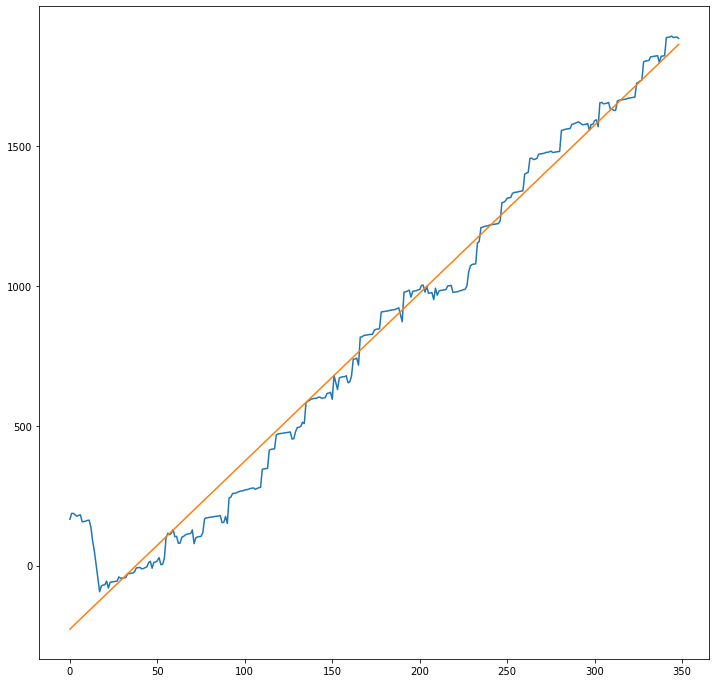

In [21]:
import random
import math
import copy
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

class TrieNode:
    def __init__(self, inputChar):
        self.char = inputChar
        self.end = False
        self.children = {}
 
class Trie():
    def __init__(self, startingElements=None):
        self.root = TrieNode("")
        if startingElements!=None:
          for i in startingElements: self.insert(i)
    def insert(self, word):
        node = self.root
        for char in word:
            if char in node.children:
                node = node.children[char]
            else:
                new_node = TrieNode(char)
                node.children[char] = new_node
                node = new_node
        node.end = True      
    def searchAndSplit(self, x):
        node = self.root
        output = ["", ""]
        for char in x:
            if char in node.children:
                node = node.children[char]            
            else:
                return []        
            output[1 if node.end else 0] += node.char
        return output if node.end else []
    def toGraph(self):
      from pyvis.network import Network
      g = Network(directed =True)      
      g.show_buttons()

      nodeIndex = 1
      currentNode = 0
      q = [self.root]      
      g.add_node(currentNode, label="", color="red")
      tempLabels = {0:""}
      while q!=[]:
        n = q.pop(0)                     
        for i in n.children.values():
          tempLabels[nodeIndex] = tempLabels[currentNode]+i.char
          g.add_node(nodeIndex, label=tempLabels[currentNode]+i.char, color="#48e073" if i.end else "blue")
          g.add_edge(currentNode, nodeIndex)
          nodeIndex+=1
          q.append(i)
        currentNode+=1
      g.show('nx.html')

class MainGame:
  def __init__(self):
    #random.seed(368) #311
    self.objects = {".":[".",0],"a":["b",1],"b":["c",5],"c":["d",25],"d":["e",125],"e":["e",625],"1":["1",-25],"2":["3",-5],"3":["4",50],"4":["4",500],"x":["x",-50]}
    self.checkAndLoadFiles()    
    self.turn = 0
    self.score = []
    self.storage = "."
    self.bigFoots = [[(i,j), 0, False] for i in range(len(self.matrix)) for j in range(len(self.matrix[0])) if self.matrix[i][j]=="1"]
    self.updateActual()
    self.tr = Trie((''.join(chr(97+int(j)) for j in str(i))+str(k) for k in range(len(self.matrix[0])) for i in range(len(self.matrix))))
    self.tr.insert("exit")
    self.tr.insert("hint")
    self.tr.insert("*")
    self.tr.toGraph()

  def checkAndLoadFiles(self):
    try:
      with open("tablero.txt", "r") as f:
        self.matrix=[]        
        for i in f.readlines():
          self.matrix.append([])
          for j in i.replace("\n", ""):
            if not j in self.objects: raise
            self.matrix[-1].append(j)
    except:
      self.matrix = [random.sample(["."]*45+["a"]*18+["b"]*4+["c"]*3+["1"]*2, 10) for i in range(10)]
      print("Error al cargar el fichero tablero, usando tablero aleatorio...")      
    try:
      with open("secuencia.txt", "r") as f:
        self.seq=""
        for i in f.readline():
          if i not in self.objects and i != "w": raise
          self.seq += i
    except:
      self.seq = ""
      print("Error al cargar el fichero secuencia, usando secuencia aleatoria...")      

  def main(self):
    print("Que empiece el juego:\U0001F609")
    self.showGame()    
    while any("." in x for x in self.matrix):
      message = self.validarEntrada("hint")#self.validarEntrada(input("Mover a casilla: ").lower().replace(" ", ""))
      while not message[0]: message = self.validarEntrada(input("Jugada errónea\nMover a casilla: ").lower().replace(" ", ""))

      if "".join(message[1])=="exit": break
      if "".join(message[1])=="*": self.storage=self.actual; self.updateActual(); self.showGame(); continue;
      coordinates = (lambda l: (int("".join([str(ord(i)%97) for i in l[0]])), int(l[1])))(message[1]) if "".join(message[1])!="hint" else self.getHint()
      if not ((self.matrix[coordinates[0]][coordinates[1]]==".") ^ (self.actual=="w")): print("Jugada errónea"); continue;

      #sample = [copy.deepcopy(self.matrix) + [[self.actual]*len(self.matrix[0])], list(coordinates)]
      #if sample not in train_dataset: train_dataset.append(sample)
      self.updateMatrix(coordinates)
      self.updateActual()
      self.turn+=1
      self.bigFoots = [[i[0], i[1]+1, i[2]] for i in self.bigFoots]
      
      self.showGame()
    print("Partida terminada, GG:\U0001F44F")
    self.plotScore()

  def getHint(self):
    prevObjs = sum(1 for a in self.matrix for b in a if b!=".")
    tempValues=[-math.inf, (0,0)]
    #debugValues = [[0]*len(self.matrix[0]) for i in range(len(self.matrix))]
    for i in range(len(self.matrix)):
      for j in range(len(self.matrix[0])):
        if (self.matrix[i][j] == ".") ^ (self.actual=="w"): 
          newObj = copy.deepcopy(g)
          newObj.updateMatrix((i,j))
          newScore = sum(sum(self.objects[b][1] - (b != "." or 0) for b in a) for a in newObj.matrix) + (prevObjs - 12*newObj.minDistanceToElement((i,j), ["1", "2", newObj.matrix[i][j]]))
          if newScore>tempValues[0]: tempValues = [newScore, (i,j)]
          #debugValues[i][j] = newScore
    #plt.imshow(debugValues, cmap='hot', interpolation='nearest')
    #plt.show()
    return tempValues[1]
  
  def plotScore(self):
    x = np.array(list(range(len(self.score))))
    m,c = self.linReg(x, self.score)
    fig = plt.figure(figsize=(12, 12))
    plt.plot(x, self.score)
    plt.plot(x, m*x + c)
    plt.show()
  
  def linReg(self, x, y):
    return np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T, y)[0]

  def minDistanceToElement(self, coordinates, elements):
    visited = set()
    q = [(coordinates, 0)]
    while q:
        n, distance = q.pop(0)
        if n in visited:
            continue
        visited.add(n)
        for i, j in ((n[0]-1, n[1]), (n[0]+1, n[1]), (n[0], n[1]-1), (n[0], n[1]+1)):
            if i < 0 or i >= len(self.matrix) or j < 0 or j >= len(self.matrix[0]): continue
            if self.matrix[i][j] in elements: return distance+1
            q.append(((i,j), distance+1))
    return 0   
  
  def updateActual(self):
    self.actual = random.choice(["a"]*30+["b"]*5+["c"]*1+["1"]*6+["w"]*1) if self.seq=="" else self.seq[self.turn%len(self.seq)]
  
  def updateMatrix(self, coordinates):
    if self.actual=="w": self.matrix[coordinates[0]][coordinates[1]] = "."; self.deleteBigFoot(coordinates); return;
    self.matrix[coordinates[0]][coordinates[1]] = self.actual
    if self.actual=="1": self.bigFoots.append([coordinates, 0, False]); self.updateBigFoots(); return;

    self.checkAndColapse(coordinates)
    self.updateBigFoots()

  def checkAndColapse(self, coordinates):
    g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
    if g[1]=="2": coordinates = max(g[0], key=lambda x:[k for k in self.bigFoots if k[0]==x][0][1])
    while len(g[0])>2:
      for i in g[0]: 
        if self.matrix[i[0]][i[1]] == "2": self.deleteBigFoot(i);
        self.matrix[i[0]][i[1]] = "."
      self.matrix[coordinates[0]][coordinates[1]] = self.objects[g[1]][0]
      g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
  
  def deleteBigFoot(self, coordinates):
    for i in range(len(self.bigFoots)):
      if self.bigFoots[i][0] == coordinates: del self.bigFoots[i]; break;

  def updateBigFoots(self):
    for i in enumerate(self.bigFoots):
      n = i[1][:]
      if not n[2] and n[1]>0:
        for j in (lambda l:[k for k in l if k[0]>=0 and k[1]>=0])(((n[0][0]-1, n[0][1]), (n[0][0], n[0][1]+1), (n[0][0]+1, n[0][1]), (n[0][0], n[0][1]-1))):
          try:
            if self.matrix[j[0]][j[1]]==".": self.matrix[j[0]][j[1]]="1"; self.matrix[n[0][0]][n[0][1]]="x" if n[1]>10 else "."; self.bigFoots[i[0]][0]=j[:]; break;
          except: pass

      if n[0]==self.bigFoots[i[0]][0]: 
        g = self.getGroup(n[0], True)
        if not "." in (self.matrix[k[0]][k[1]] for k in g):
          for j in g: self.matrix[j[0]][j[1]] = "2"; bfIndex = [k for k in range(len(self.bigFoots)) if self.bigFoots[k][0]==j][0]; self.bigFoots[bfIndex][2]=True;  
          self.checkAndColapse(n[0])

  def getGroup(self, coordinates, bigFootMode=False):    
    visited = set()
    output = [coordinates]
    q = [coordinates]
    while q!=[]:
      n = q.pop(0)
      visited.add(n)
      for i in ((n[0]-1, n[1]), (n[0], n[1]+1), (n[0]+1, n[1]), (n[0], n[1]-1)):
        if i[0] < 0 or i[0] >= len(self.matrix) or i[1] < 0 or i[1] >= len(self.matrix[0]): continue
        if (not i in visited) and (self.matrix[i[0]][i[1]]==self.matrix[coordinates[0]][coordinates[1]] or (bigFootMode and self.matrix[i[0]][i[1]]==".")): q.append(i); output.append(i);
    return output

  def validarEntrada(self, s):
    s = self.tr.searchAndSplit(s)
    return (True if s else False, s)

  def showGame(self):
    df = pd.DataFrame(self.matrix, columns=list(range(len(self.matrix[0]))), index=[''.join(chr(65+int(j)) for j in str(i)) for i in range(len(self.matrix))])
    display(HTML(df.to_html()))
    self.score.append(sum(self.objects[j][1] for i in self.matrix for j in i))
    print(f"\nTurno: {self.turn} Puntos:{self.score[-1]}\nAlmacen: [{self.storage}] Actual: [{self.actual}]")

if __name__=="__main__":  
  g = MainGame()
  g.main()

**Bot Encoding**

In [2]:
import pickle
import urllib

with urllib.request.urlopen("https://github.com/cardstdani/practica-par/blob/main/dataset.txt?raw=true") as fp:
  train_dataset=pickle.load(fp)

In [6]:
len(train_dataset)

10025

In [ ]:
with open('dataset.txt', 'wb') as fp:
    pickle.dump(train_dataset, fp)

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (4, 4), activation='relu', input_shape=(11, 10, 1)),
    tf.keras.layers.Dense(128, activation = tf.keras.activations.relu),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation = tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l1(0.04), activity_regularizer=tf.keras.regularizers.l1(0.04),  kernel_initializer='he_normal'),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(112, activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.tanh)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

epochs = 100
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))

f = lambda x:[[ord(j) for j in i] for i in x]
g = lambda x: x[1]+x[0]*len(train_dataset[0][0][0])
history = model.fit(x=np.array([np.array(f(i[0])) for i in train_dataset]), y=np.array([g(i[1]) for i in train_dataset]), epochs=epochs, callbacks=[])

1/1 [==============================] - 0s 185ms/step
(3, 9) [0, 4]


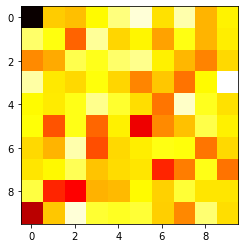

1/1 [==============================] - 0s 37ms/step
(3, 9) [3, 4]


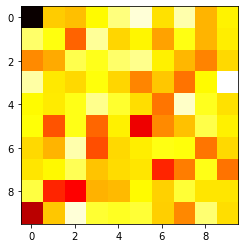

1/1 [==============================] - 0s 26ms/step
(3, 9) [8, 6]


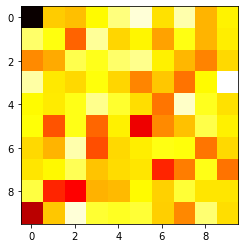

1/1 [==============================] - 0s 27ms/step
(3, 9) [7, 8]


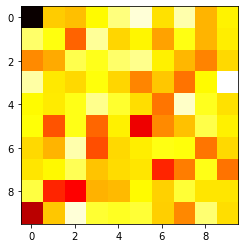

1/1 [==============================] - 0s 27ms/step
(3, 9) [5, 6]


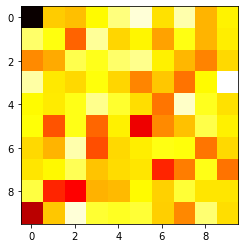

1/1 [==============================] - 0s 26ms/step
(3, 9) [9, 6]


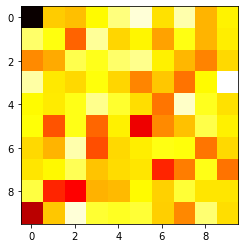

1/1 [==============================] - 0s 29ms/step
(3, 9) [1, 7]


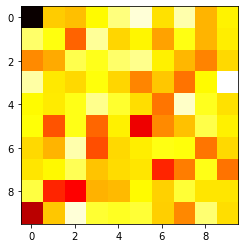

1/1 [==============================] - 0s 31ms/step
(3, 9) [8, 4]


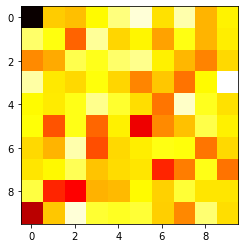

1/1 [==============================] - 0s 31ms/step
(3, 9) [0, 2]


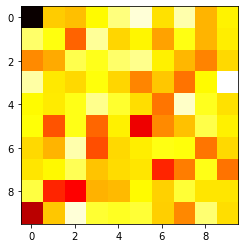

1/1 [==============================] - 0s 25ms/step
(3, 9) [4, 7]


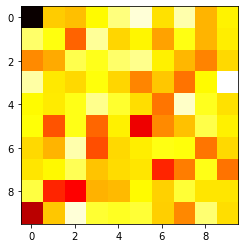

In [ ]:
for i in random.sample(range(len(train_dataset)), 10):
  pred = model.predict(np.array([f(train_dataset[i][0])]))[0].reshape(10, 10)
  print(np.unravel_index(np.argmax(pred), pred.shape), train_dataset[i][1])
  plt.figure()
  plt.imshow(pred, cmap="hot")  
  plt.show()

In [ ]:
import copy
copyObj = copy.copy(g)

In [ ]:
copyObj.__dict__

{'objects': {'.': ['.', 0],
  'a': ['b', 1],
  'b': ['c', 5],
  'c': ['d', 25],
  'd': ['e', 125],
  'e': ['e', 625],
  '1': ['1', -25],
  '2': ['3', -5],
  '3': ['4', 50],
  '4': ['4', 500],
  'x': ['x', -50]},
 'matrix': [['b', 'a', 'a', '2', 'a', '2', 'a', 'a', '3', 'a'],
  ['2', 'a', '2', 'a', '2', 'a', '2', 'a', '2', 'a'],
  ['a', '2', 'a', 'c', 'a', 'b', 'a', 'c', 'a', 'b'],
  ['a', 'c', 'a', '3', 'a', '2', 'a', '2', 'a', 'b'],
  ['b', '2', 'c', '2', '2', 'c', '3', 'a', 'c', '2'],
  ['b', 'a', '2', 'a', 'b', 'a', 'c', 'a', '2', 'a'],
  ['a', 'b', '2', 'c', 'd', '2', 'a', '3', 'a', 'a'],
  ['a', 'b', 'd', 'a', 'a', 'c', 'a', 'd', 'a', '2'],
  ['d', '3', 'b', '2', 'c', 'x', 'b', '2', 'a', 'a'],
  ['a', 'b', 'a', 'a', 'c', '2', 'a', 'a', '2', 'a']],
 'seq': '',
 'turn': 227,
 'score': [-14,
  7,
  10,
  5,
  6,
  7,
  28,
  49,
  50,
  51,
  52,
  53,
  -44,
  -3,
  -2,
  -1,
  4,
  -1,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  20,
  15,
  28,
  23,
  24,
  27,
  28,
  43,
 

Que empiece el juego:😉


,0,1,2,3,4,5
A,a,.,a,2,b,.
B,.,1,.,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,1,.
F,.,a,a,c,.,b



Turno: 7 Puntos:116
Almacen: [.] Actual: [a]
Mover a casilla: a1


,0,1,2,3,4,5
A,.,b,.,2,b,.
B,.,.,1,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,1,c
E,a,.,a,a,.,.
F,.,a,a,c,.,b



Turno: 8 Puntos:119
Almacen: [.] Actual: [1]
Mover a casilla: a5


,0,1,2,3,4,5
A,.,b,1,2,b,1
B,.,.,.,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,1,.
F,.,a,a,c,.,b



Turno: 9 Puntos:94
Almacen: [.] Actual: [a]
Mover a casilla: exit
Partida terminada, GG:👏


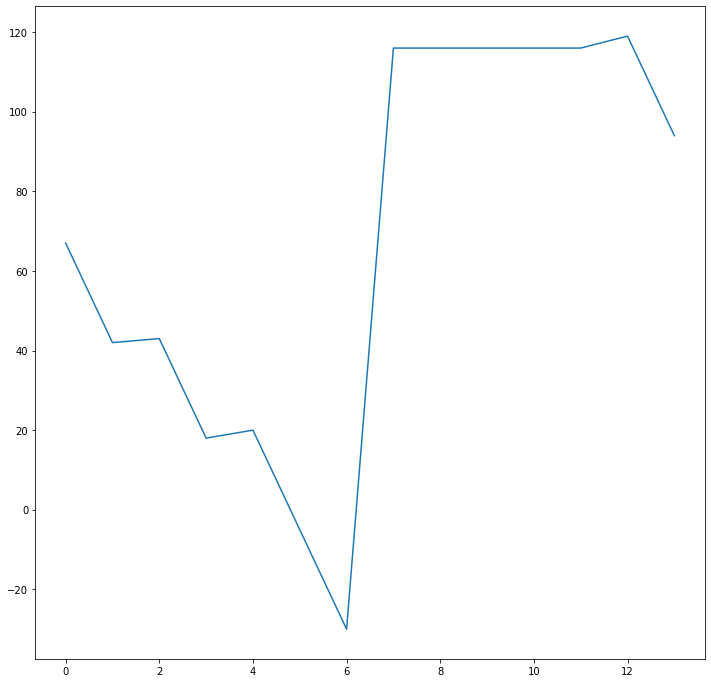

In [ ]:
copyObj.main()